<a href="https://colab.research.google.com/github/JotaBlanco/F1_Data/blob/main/F1_Lapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Lapping
Based on periodicity of data, guess if a car is lapping and if so, predict when is next braking event happening.

## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 0103 Load Datasets
Data can be found ([here](https://github.com/MrPranz/F1-Telemetry)). 

In [19]:
import csv
import numpy as np

def processtelemetry(csvfile,thrcut=1,brkcut=1,tb=False):
	# inputs:
	# csvfile = csv file as string
	# thrcut = normalised cut off value for throttle data. Sets this value as the max instead of the true max.
	# brkcut = normalised cut off value for brake data. Sets this value as the max instead of the true max.
	# tb = True if csv file has throttle/brake data, boolean.

	# outputs: 
	# v = 1d array of velocity
	# f = 1d array of time
	# d = 1d array of distance
	# [dtb,thr,brk] = array of 3x1d arrays of distance, throttle, and brake

	# read csv file
	with open(csvfile,'r') as file:
		reader = csv.reader(file)
		v_ocr,t_ocr,thr_ocr,brk_ocr = list(reader)

	v_all = []
	t_all = []
	thr_all = []
	brk_all = []

	# since the raw output from ocr is not always numeric, its converted to floats here where possible
	for j in range(0,len(v_ocr),1):
		try:
			vj = [float(v_ocr[j])]
			tj = [float(t_ocr[j])]
		except ValueError:
			vj = [-1]
			tj = [t_ocr[j]]
		v_all = v_all + vj
		t_all = t_all + tj
		if tb == True:
			try:
				thr_all = thr_all + [thr_ocr[j]]
				brk_all = brk_all + [brk_ocr[j]]
			except IndexError:
				pass

	# find and remove odd speed values
	kidx = []
	for k in range(len(v_all)):
		if v_all[k] == -1 or v_all[k] > 400 or v_all[k] < 30:
			kidx = kidx + [k]
	vc1 = np.delete(v_all,kidx)
	tc1 = np.delete(t_all,kidx)
	thr = np.delete(thr_all,kidx).astype(float)
	brk = np.delete(brk_all,kidx).astype(float)
	v,t = vc1,tc1

	# create distance array for throttle and brake traces
	dtb = np.array([0])
	tc1 = tc1.astype(float)
	for s in range(0,len(vc1)-1):
		dtbi = (vc1[s]+vc1[s+1])*(tc1[s+1]-tc1[s])*0.5/3.6
		dtb = np.append(dtb,dtbi+dtb[s])

	# create distance array for velocity trace
	d = np.array([0])
	t = t.astype(float)
	for n in range(len(v)-1):
		di = (v[n]+v[n+1])*(t[n+1]-t[n])*0.5/3.6
		d = np.append(d,di+d[n]) 

	# Since the throttle and brake data is the pixel count, these are normalised and converted. 
	# Pixel counts can vary a lot so thrcut and brkcut serve to fix this. For thrcut, it also serves
	# to remove the DRS addition of green pixels. 
	if tb:
		thrmax = max(np.extract(thr < thrcut*max(thr),thr))
		brkmax = max(np.extract(brk < brkcut*max(brk),brk))

		for i in range(len(thr)):
			if thr[i] > thrmax:
				thr[i] = thrmax
			if brk[i] > brkmax:
				brk[i] = brkmax 
			if brk[i] < 0.75*brkmax:
				brk[i] = 0
		thr = thr*(100/max(thr))
		brk = brk*(1/max(brk))

		# this next bit transforms the throttle curve past 30% throttle to account for the white text in the graphic.
		l1,l2 = 30,30
		u1,u2 = 60,67
		v1,v2 = 100,100
		k1,k2 = u1,u2

		r = (k2-v1)/(k1-v1)
		s = (u2-l1)/(u1-l1)

		for i2 in range(len(thr)):
			if thr[i2] > l1 and thr[i2] < u1:
				thr[i2] = s*(thr[i2]-l1) + l1
			elif thr[i2] > k1:
				thr[i2] = r*(thr[i2]-v1) + v1
	else:
		pass

	dtot = str(max(d))
	print(csvfile[0:-4],"completed. Distance =",dtot[0:6]+'m',",Time =",max(t),'seconds')
	f = t

	return v,f,d,[dtb,thr,brk]

# dictionary of parameters for each lap
params = {
		'AUS':
			{},
		'CHI':
			{},
		'BAH':
			{},
		'RUS':
			{},
		'SPA':
			{'num':5,'length':4655,'title':'F1 2017 R05 Spain - Circuit de Catalunya',
			'HAM':{'thr':0.7,'brk':0.75,'tb':True,'label':'Hamilton: 01.19.149','colour':'c'},
			'BOT':{'thr':0.66,'brk':0.5,'tb':True,'label':'Bottas: 01.19.390','colour':'#005656'},
			'VET':{'thr':1,'brk':1,'tb':True,'label':'Vettel: 01.19.200','colour':'r'},
			'VER':{'thr':1,'brk':1,'tb':False,'label':'Verstappen: 01.19.706','colour':'#440044'},
			'ALO':{'thr':1,'brk':1,'tb':False,'label':'Alonso: 01.21.076','colour':'#ff8200'}},
		'MON':
			{'num':6,'length':3337,'title':'F1 2017 R06 Monaco - Circuit de Monaco',
			'RAI':{'thr':1,'brk':1,'tb':False,'label':'Raikkonen: 01.12.178','colour':'r'},
			'VET':{'thr':0.7,'brk':0.05,'tb':True,'label':'Vettel: 01.12.221','colour':'#960000'},
			'BOT':{'thr':0.925,'brk':0.1,'tb':True,'label':'Bottas: 01.12.559','colour':'c'},
			'VER':{'thr':1,'brk':1,'tb':False,'label':'Verstappen: 01.12.496','colour':'#690069'},
			'RIC':{'thr':1,'brk':1,'tb':False,'label':'Ricciardo: 01.13.094','colour':'#ec00ec'},
			'BUT':{'thr':1,'brk':1,'tb':False,'label':'Button: 01.13.613','colour':'#ff9500'}},
		'CAN':
			{'num':7,'length':4361,'title':'F1 2017 R07 Canada - Circuit Gilles Villeneuve',
			'HAM':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Hamilton: 01.11.459','colour':'c'},
			'VET':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Vettel: 01.11.789','colour':'r'},
			'VER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Verstappen: 01.12.403','colour':'#690069'},
			'PER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Perez: 01.13.018','colour':'#ff70ff'},
			'ALO':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Alonso: 01.13.693','colour':'#ff9500'}},
		'AZE':
			{'num':8,'length':6003,'title':'F1 2017 R08 Azerbaijan - Baku City Circuit',
			'HAM':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Hamilton: 01.40.593','colour':'c'},
			'BOT':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Bottas: 01.41.027','colour':'#005656'},
			'RAI':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Raikkonen: 01.41.693','colour':'r'},
			'VET':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Vettel: 01.41.841','colour':'#960000'},
			'VER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Verstappen: 01.41.879','colour':'#690069'}},
		}

In [79]:
# Url archivo raw
url = 'https://raw.githubusercontent.com/MrPranz/F1-Telemetry/master/10_GBR_GP/2017_gbr_ham.csv'
url = 'https://raw.githubusercontent.com/MrPranz/F1-Telemetry/master/10_GBR_GP/2017_gbr_ham16.csv'
file_name = url.split("/")[-1]

# Importa csv
df = pd.read_csv(url)

# Visualización primeras filas
df.to_csv(file_name, index=False)

In [76]:
df.head()

,254,254.1,259,259.1,259.2,259.3,259.4,259.5,259.6,259.7,259.8,259.9,259.10,259.11,259.12,259.13,259.14,259.15,259.16,259.17,259.18,266,266.1,266.2,266.3,266.4,266.5,268,268.1,268.2,268.3,268.4,268.5,268.6,268.7,270,270.1,270.2,270.3,270.4,...,240.4,240.5,240.6,240.7,241.19,241.20,241.21,241.22,241.23,241.24,241.25,244,244.1,244.2,244.3,244.4,244.5,244.6,244.7,244.8,244.9,244.10,244.11,244.12,244.13,244.14,244.15,244.16,244.17,244.18,244.19,244.20,244.21,244.22,244.23,244.24,244.25,244.26,244.27,244.28
0,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,...,85.82,85.84,85.86,85.88,85.9,85.92,85.94,85.96,85.98,86.0,86.02,86.04,86.06,86.08,86.1,86.12,86.14,86.16,86.18,86.2,86.22,86.24,86.26,86.28,86.3,86.32,86.34,86.36,86.38,86.4,86.42,86.44,86.46,86.48,86.5,86.52,86.54,86.56,86.58,86.6
1,4704.0,4675.00,4621.00,4603.00,4683.00,4662.0,4641.00,4638.00,4711.00,4709.00,4636.0,4671.00,4706.00,4641.00,4561.00,4700.0,4642.00,4583.00,4748.00,4729.00,4563.0,4580.00,4719.00,4563.00,4537.00,4750.0,4677.00,4721.00,4727.00,4642.00,4688.0,4714.00,4596.00,4704.00,4675.00,4621.0,4603.00,4683.00,4662.00,4641.00,...,4585.00,4607.00,4606.00,4580.00,4563.0,4579.00,4609.00,4584.00,4588.00,4562.0,4599.00,4617.00,4614.00,4613.00,4616.0,4609.00,4599.00,4587.00,4599.00,4584.0,4556.00,4592.00,4584.00,4573.00,4610.0,4592.00,4613.00,4609.00,4612.00,4605.0,4596.00,4588.00,4603.00,4592.00,4602.0,4627.00,4629.00,4621.00,4631.00,4633.0
2,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0


In [81]:
v,f,d,[dtb,thr,brk] = processtelemetry(file_name,thrcut=1,brkcut=1,tb=True)

2017_gbr_ham16 completed. Distance = 5830.8m ,Time = 89.34 seconds


In [77]:
df_ham = pd.DataFrame({'Speed': v, 
                       'Time': f, 
                       'Distance': d})

In [82]:
df_ham_2 = pd.DataFrame({'Speed': v, 
                       'Time': f, 
                       'Distance': d})

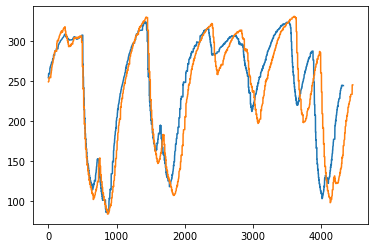

In [83]:
plt.plot(df_ham['Speed'])
plt.plot(df_ham_2['Speed'])
plt.show()

# Check patterns

In [84]:
interval = 5

df_ham['Acc'] = ((df_ham['Speed']-
                  df_ham['Speed'].shift(interval))>0).astype(int)
df_ham['Acc_Ac'] = df_ham['Acc'].rolling(interval).sum()
df_ham['Last_Ext'] = df_ham['Acc'].rolling(interval).sum()
df_ham['Acc_Ac_Chg'] = ((df_ham['Acc_Ac']-df_ham['Acc_Ac'].shift(interval)).abs()>0).astype(int)
df_ham.head(50)

,Speed,Time,Distance,Acc,Acc_Ac,Last_Ext,Acc_Ac_Chg
0,254.00,0.00,0.000000,0,NaN,NaN,0
1,254.10,0.02,1.411389,0,NaN,NaN,0
2,259.00,0.04,2.836667,0,NaN,NaN,0
3,259.10,0.06,4.275833,0,NaN,NaN,0
4,259.20,0.08,5.715556,0,0.0,0.0,0
5,259.30,0.10,7.155833,1,1.0,1.0,0
6,259.40,0.12,8.596667,1,2.0,2.0,0
7,259.50,0.14,10.038056,1,3.0,3.0,0
8,259.60,0.16,11.480000,1,4.0,4.0,0
9,259.70,0.18,12.922500,1,5.0,5.0,1


In [103]:
def last_extreme(img, extreme_up, extreme_low):
  if img['Acc'][-1] == extreme_up:
    value == extreme_up
  elif img['Acc'][-1] == extreme_low:
    value == extreme_low
  else:
    value = img['Last_Ext'][-1]
  return value

In [101]:
def rolling_pipe(dataframe, window, function):
    return pd.Series([dataframe.iloc[i-window: i].pipe(function) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index) 



In [100]:
df_ham.iloc[100-5: 100]

,Speed,Time,Distance,Acc,Acc_Ac,Last_Ext,Acc_Ac_Chg
95,287.3,1.90,143.465944,1,5.0,5.0,1
96,287.4,1.92,145.062333,1,5.0,5.0,1
97,287.5,1.94,146.659278,1,5.0,5.0,1
98,287.6,1.96,148.256778,1,5.0,5.0,0
99,287.7,1.98,149.854833,1,5.0,5.0,0


In [104]:
df_ham.pipe(rolling_pipe, 3, lambda x: last_extreme(x, 5, 0))

KeyError: ignored

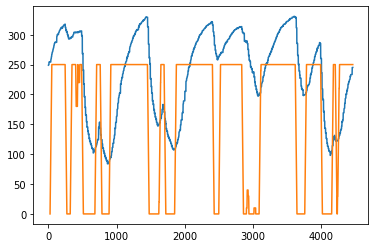

In [72]:
plt.plot(df_ham['Speed'])
plt.plot(df_ham['Acc_Ac']*10)

In [55]:
df_ham['Acc']

0       0
1       1
2       1
3       1
4       1
       ..
4463    1
4464    1
4465    1
4466    1
4467    1
Name: Acc, Length: 4468, dtype: int64

# 02 EDA
Realizaremos un pequeño análisis exploratorio visual para familiarizarnos con el dataset. 

Recuerda que puedes encontrar mis clases sobre análisis exploratorio [aquí](https://github.com/JotaBlanco/TheValley/tree/main/EDA/).

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Visualización coeficientes Pearson
plt.figure(figsize=(12,9))
sns.heatmap(np.round(df.corr(),2), 
            vmin=-1, vmax=1, 
            annot=True, cmap="coolwarm")
plt.show()

# 03 Construcción árbol de decisión a mano
Nunca lo haremos en la vida real, pero para afianzar el entendimiento de este tipo de algoritmos, vamos a reproducir el proceso de entrenamiento a mano.

## 0301 DataFrame
Para simplificar, haremos esto con un dataframe consistente solo en las columnas ['baseline value', 'accelerations', 'fetal_movement', 'fetal_health'] renombradas como ['Base', 'Acc', 'Mov', 'Salud Feto'].

In [ ]:
df.columns

In [ ]:
df_resumen = df[['baseline value', 'accelerations', 'fetal_movement', 'fetal_health']]
df_resumen.columns = ['Base', 'Acc', 'Mov', 'Salud Feto']
df_resumen.head(7)

## 0301 Seleccionamos el nodo raíz
Para seleccionar el nodo raíz generaremos árboles muy sencillos, de solo 3 nodos (una sola partición).

### 030101 Variable categórica
En este dataset resumen no tenemos una variable categórica binaria, pero generamos una a partir de una partición sobre una variable continua (por ejemplo Base > 132).

A partir de esa nueva variable categórica binaria probamos a generar una partición.

In [ ]:
df_resumen_i = df_resumen.copy(deep=True)
filtro_i = df_resumen_i['Base'] > 132
df_resumen_i['base > 132'] = filtro_i.astype(int)
df_resumen_i.head()

In [ ]:
# Podemos hacer la partición Anemia = 1 y Anemia = 0 con un groupby
df_i = df_resumen_i.groupby(['base > 132','Salud Feto'])['Base'].agg(['count']).reset_index()
df_i

In [ ]:
def particion_categorica(df, target, var_discreta):
  """
  Genera un dataframe con información sobre la partición utilizando la variable
  discreta binaria aportada.
  """
  df_i = df.groupby([var_discreta,target])[df.columns[0]].agg(['count']).reset_index()
  
  return df_i.sort_values(var_discreta, ascending=True).reset_index(drop=True)

### 030102 Variable Continua
Las variables continuas pueden dar lugar a diversas particiones. Veamos la variable 'Base' como ejemplo.

In [ ]:
def particiones_continuas(df, target, var_continua):
  """
  Muestra una serie dataframes con información sobre las distintas particiones 
  posibles utilizando la variable continua aportada.
  """
  valores_unicos_ordenados = df[var_continua].sort_values().unique()
  valores_particiones = (valores_unicos_ordenados[:-1] + 
                         valores_unicos_ordenados[1:])/2

  for valor in valores_particiones:
    df_i = df.copy(deep=True)
    filtro_i = df_i[var_continua] > valor
    df_i[str(var_continua) + ' > ' + str(valor)] = filtro_i.astype(int)
    df_i = particion_categorica(df_i, 
                                target, 
                                str(var_continua) + ' > ' + str(valor))
    display(df_i)

In [ ]:
particiones_continuas(df_resumen, 'Salud Feto', 'Base')

### 030103 Impureza de Gini
Calculamos la impureza de Gini de cada una de las particiones.

In [ ]:
df_i

In [ ]:
def gini(df_i):
  """
  Calcula el Gini para cada nodo el ponderado de la decisión.
  """
  for nodo in [0, 1]:
    gini = 1
    filtro_condicion = df_i[df_i.columns[0]]==nodo
    for clase in df_i.loc[filtro_condicion, df_i.columns[1]]:
      conteo_i = int(df_i.loc[((filtro_condicion)&(df_i[df_i.columns[1]]==clase)), 'count'])
      prob_i = conteo_i/df_i.loc[filtro_condicion, 'count'].sum()
      gini = gini - prob_i**2
    
    df_i.loc[filtro_condicion,'Gini'] = gini
  
  df_i_group = df_i.groupby([df_i.columns[0], 'Gini'])['count'].agg('sum').reset_index()
  gini_pond = (df_i_group['count'][0] * df_i_group['Gini'][0] +  
               df_i_group['count'][1] * df_i_group['Gini'][1])/(df_i_group['count'].sum())
  
  df_i['Gini Media Pond'] = gini_pond
  return df_i

In [ ]:
gini(df_i)

In [ ]:
def particion_categorica(df, target, var_discreta):
  """
  Genera un dataframe con información sobre la partición utilizando la variable
  discreta binaria aportada.
  """
  df_i = df.groupby([var_discreta,target])[df_resumen_i.columns[0]].agg(['count']).reset_index()
  df_i = df_i.sort_values(var_discreta, ascending=True).reset_index(drop=True)
  return gini(df_i)

### 030104 Cuál es la mejor partición?

In [ ]:
def mejor_particion_continua(df, target, var_continua):
  """
  Devuelve un dataframe con información sobre la partición ópitma de entre las 
  posibles utilizando la variable continua aportada.
  """
  valores_unicos_ordenados = df[var_continua].sort_values().unique()
  valores_particiones = (valores_unicos_ordenados[:-1] + 
                         valores_unicos_ordenados[1:])/2
  particion_optima = []

  for i, valor in enumerate(valores_particiones):
    df_i = df.copy(deep=True)
    filtro_i = df_i[var_continua] > valor
    df_i[str(var_continua) + ' > ' + str(valor)] = filtro_i.astype(int)
    df_i = particion_categorica(df_i, 
                                target, 
                                str(var_continua) + ' > ' + str(valor))

    if i == 0:
      particion_optima = df_i
    else:
      if df_i['Gini Media Pond'][0] < particion_optima['Gini Media Pond'][0]:
        particion_optima = df_i
    
  return particion_optima

In [ ]:
mejor_particion_continua(df_resumen, 'Salud Feto', 'Base')

In [ ]:
mejor_particion_continua(df_resumen, 'Salud Feto', 'Acc')

In [ ]:
mejor_particion_continua(df_resumen, 'Salud Feto', 'Mov')

In [ ]:
def seleccion_particion(df, target, lista_vars_continuas, lista_vars_binarias):
  particion_optima = []

  for i, var in enumerate(lista_vars_continuas+lista_vars_binarias):
    if var in lista_vars_continuas:
      df_i = mejor_particion_continua(df, target, var)
    if var in lista_vars_binarias:
      df_i = particion_categorica(df,  target, var)
    

    if i == 0:
      particion_optima = df_i
    else:
      if df_i['Gini Media Pond'][0] < particion_optima['Gini Media Pond'][0]:
        particion_optima = df_i
    
  return particion_optima

In [ ]:
seleccion_particion(df_resumen, 'Salud Feto', ['Base', 'Acc', 'Mov'], [])

## 0302 Construímos las ramas
Vamos a contruír el resto del árbol sin repetir variables.

In [ ]:
# Realizamos la partición
df_resumen_1 = df_resumen[df_resumen['Acc']>0.0005]
df_resumen_2 = df_resumen[df_resumen['Base']<0.0005]

In [ ]:
df_resumen.columns

### 030201 Rama Izquierda (1)

In [ ]:
# Siguiente partición
seleccion_particion(df_resumen_1, 'Salud Feto', ['Base', 'Acc', 'Mov'], [])

In [ ]:
# Realizamos la siguiente partición
df_resumen_1_1 = df_resumen[((df_resumen['Acc']>0.0005)&(df_resumen['Acc']>0.0025))]
df_resumen_1_2 = df_resumen[((df_resumen['Acc']>0.0005)&(df_resumen['Acc']<0.0025))]

In [ ]:
# Siguiente partición
seleccion_particion(df_resumen_1_1, 'Salud Feto', ['Base', 'Acc', 'Mov'], [])

In [ ]:
# Siguiente partición
seleccion_particion(df_resumen_1_2, 'Salud Feto', ['Base', 'Acc', 'Mov'], [])

# 04 Construcción árbol de decisión con scikit learn
Ahora de manera automática, utilizando la librería [scikit learn](https://scikit-learn.org/stable/), la libería básica de referencia para machine learning.

## 0401 Importamos las librerías

In [ ]:
# Nos importamos las funciones de árboles de scikit learn
from sklearn import tree

## 0402 Inicializamos el árbol
Definiendo las características que tendrá.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [ ]:
# Inicializamos un árbol. Por ahora está vacío. 
# Solo definimos cómo queremos que sea en cuanto a su estructura y condiciones de entrenamiento
arbol = tree.DecisionTreeClassifier(max_depth=3)
arbol

## 0403 Entrenamos el modelo
Una vez inicializado y definido el árbol, el método .[fit()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit) realiza el proceso de particionado recursivo que hemos hecho nosotros antes a mano.

In [ ]:
# Entrenamos el árbol inicializado a partir de los datos que le pasemos con .fit()
arbol = arbol.fit(X = df_resumen[['Base', 'Acc', 'Mov']],  # vars descriptivas
                  y = df_resumen[['Salud Feto']])                  # var objetico
arbol

##0404 Visualizamos el modelo
Una vez entrenado el modelo, podemos visualizarlo.

In [ ]:
# Con el método export_text en un print()
esquema_print = tree.export_text(arbol, 
                                 feature_names= ['Base', 'Acc', 'Mov'])
print(esquema_print)

In [ ]:
# O con la librería graphviz
import graphviz 

# Export_graphviz
dot_data = tree.export_graphviz(arbol, 
                                out_file=None, 
                                feature_names= ['Base', 'Acc', 'Mov']) 
graph = graphviz.Source(dot_data) 
graph

## 0405 Realizamos una predicción
Una vez el modelo está entrenado (definido) podemos pasarle datos para obtener las prediciones correspondientes de la variable objetivo. 

Para esto utilizamos el método .[predict()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict).

In [ ]:
# Predicción
prediccion = arbol.predict(df_resumen[['Base', 'Acc', 'Mov']])
prediccion

In [ ]:
# Cómo de buena es la predicción?
from sklearn.metrics import accuracy_score
accuracy_score(df_resumen['Salud Feto'], prediccion)

# 05 EJERCICIO
Entrena un árbol de decisión con todas las variables del set de datos de salud del feto, y evalua si la predicción es mejor o peor que utilizando tres variables (que es lo que acabamos de hacer en la sección anterior).

Hazlo primero manteniendo una profundidad de 3 como en el ejemplo anterior y luego prueba también con 5 y 20.

In [ ]:
df.head(2)

In [ ]:
df.columns

In [ ]:
# Inicializamos un árbol. Por ahora está vacío. Solo definimos cómo queremos que sea.
arbol_3 = tree.DecisionTreeClassifier(max_depth=3)
arbol_5 = tree.DecisionTreeClassifier(max_depth=5)
arbol_20 = tree.DecisionTreeClassifier(max_depth=20)

In [ ]:
# Matrices de datos
cols = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency']
X = df[cols]
y = df['fetal_health']

In [ ]:
# Entrenamos los árboles inicializados a partir de los datos que le pasemos con .fit()
arbol_3 = arbol_3.fit(X = X, y = y)
arbol_5 = arbol_5.fit(X = X, y = y)
arbol_20 = arbol_20.fit(X = X, y = y)

In [ ]:
# Podemos visualizar la estructura
print(tree.export_text(arbol_3, 
                       feature_names=list(X.columns)))

In [ ]:
# Podemos visualizar la estructura
print(tree.export_text(arbol_5, 
                       feature_names=list(X.columns)))

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(arbol_5, 
                                out_file=None, 
                                feature_names=list(X.columns)) 
graph = graphviz.Source(dot_data) 
graph

In [ ]:
# Predicción
prediccion_3 = arbol_3.predict(X)
prediccion_5 = arbol_5.predict(X)
prediccion_20 = arbol_20.predict(X)

In [ ]:
# Precisión de la predicción
print('Precisión de arbol depth=3 es de ',accuracy_score(y, prediccion_3))
print('Precisión de arbol depth=5 es de ',accuracy_score(y, prediccion_5))
print('Precisión de arbol depth=20 es de ',accuracy_score(y, prediccion_20))